<a href="https://colab.research.google.com/github/maxkkessler/CSE-4820/blob/main/CSE_4820_Recurrent_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSE 4820/5819**: Assignment 4 
**Part II** [25 Points Total]

**Due**: **End of Day, Dec 14**

In this assignment you will use Keras to build a recurrent neural network to predict the daily closing price of a stock of your choosing. If you are unsure what to use, you can check out this list on [NASDAQ](https://www.nasdaq.com/market-activity/stocks/screener) or just use Tesla's stock which has the ticker symbol TSLA.

## Load some necessary libraries

In [305]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

To get stock data, we will use the `yfinance` library. You can read more about it [here](https://pypi.org/project/yfinance/).

In [291]:
# This library isn't part of Colab, but we can install it
!pip install yfinance

import yfinance as yf

The ticker symbol for Tesla is TSLA. The start date will be January 1, 2018, and the end date will be December 1, 2021. We will use daily prices. If you want to use a different stock, replace TSLA with the appropriate ticker symbol.

In [292]:
df = yf.download("TSLA", start="2016-01-01", end="2021-12-01", interval="1d")

[*********************100%***********************]  1 of 1 completed


Let's take a look at what we have:

In [293]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,46.144001,46.276001,43.799999,44.681999,44.681999,34135500
2016-01-05,45.271999,45.377998,44.000000,44.686001,44.686001,15934000
2016-01-06,44.000000,44.009998,43.195999,43.807999,43.807999,18895500
2016-01-07,42.838001,43.688000,42.734001,43.130001,43.130001,17771500
2016-01-08,43.571999,44.088001,42.153999,42.200001,42.200001,18140500


## Create the datasets

We need to decide what timeframe will belong to the training set, and testing set.

Partition the data:
* The **training** data will be from January 1 2016 - December 31 2020.
* The **testing** data will be from January 1 2021 - December 1 2021. 

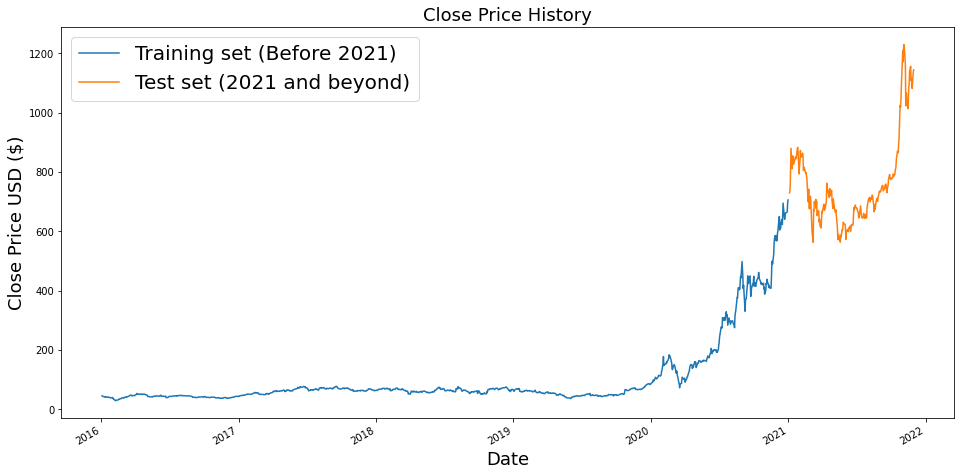

In [294]:
# We have chosen 'Close' attribute for prices. Let's see what it looks like
df["Close"][:'2020'].plot(figsize=(16,8),legend=True)
df["Close"]['2021':].plot(figsize=(16,8),legend=True)
plt.legend(['Training set (Before 2021)','Test set (2021 and beyond)'], loc='upper left', prop={'size': 20})
plt.title('Close Price History', fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [295]:
# split into train and test sets using 'Close' and convert the dataframe to a numpy array
train_set = df[:'2020'].iloc[:,3:4].values
test_set = df['2021':].iloc[:,3:4].values

In [296]:
print(len(train_set), len(test_set))

1259 230


## Question 1: Preprocessing the data [1 Point]:

Use either the `MinMaxScaler` or `StandardScaler` to appropriately normalize/standardize the data. Make sure to only use the `fit` method on the training data.

In [297]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Copy=True allows us to make a copy of the data that is scaled rather then just scaling the data
scaler = StandardScaler(copy=True)
# scaler = MinMaxScaler(copy=True)

# Fit the data by the scalers and then transform it
train_set = scaler.fit_transform(train_set)







## Question 2: Creating the Training Samples [1 Point]:

In [298]:
# We create a data structure with look_back number timesteps and 1 output
# So for each element of training set, we have look_back previous training set elements 

# You can use the following function to create the training set

def create_training_samples(data, look_back):
  X_train = []
  y_train = []
  for i in range(look_back,len(data)):
      X_train.append(data[i-look_back:i,0])
      y_train.append(data[i,0])
  return np.array(X_train), np.array(y_train)

Use the above function to create the training data based on the normalized/standardized data from Question 1. The parameter `look_back` is your choice, and will impact the performance of the model. Running the model with a few different choices will be beneficial; specify your final choice.

Hint: Look back at tutorial 4, it's very similar.

In [299]:
# How many days we look at before predicting the next day
look_back = 10

# Creates the training data and labels for the Recurrent Network
X_train, Y_train = create_training_samples(train_set, look_back)



In [300]:
print(X_train.shape)
print(Y_train.shape)

(1249, 10)
(1249,)


Recall that in Keras, we need the input data to have a specific format, that is:

$$[\text{batch size}, \text{time steps}, \text{dimensionality}]$$

In [301]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))


## Question 3: Creating the Testing Samples [1 Point]:

We will carefully create the testing set. Since we use a `look_back` length sequence to predict the following closing day price there is a discontinuity between the training and testing sets. Specifically, the last `look_back` number of days in the training set are needed to predict the first closing price of the testing set. 

In [302]:
# We get the test set ready in a similar way as the training set but account for the data needed to predict the early test set values.

dataset_total = pd.concat((df["Close"][:'2020'],df["Close"]['2021':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - look_back:].values
inputs = inputs.reshape(-1,1)

# Use the scaler you created in Question 1 to transform the inputs
inputs  = scaler.fit_transform(inputs)


In [303]:
# Preparing X_test and predicting the prices
def fix_test(inputs):
  X_test = []
  for i in range(look_back,len(test_set)+look_back):
      X_test.append(inputs[i-look_back:i,0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
  return X_test

X_test = fix_test(inputs)


## Some helpful functions

In [304]:
# Helpful Functions

#Get the root mean squared error (RSME)
def return_rmse(predicted, test):
  return np.sqrt( np.mean( predicted - test )**2 )

def plot_predictions(df_train, df_test, predictions):
  df_test['Predictions'] = predictions

  #Visualize the data
  plt.figure(figsize=(16,8))
  plt.title('Close Price History with Model Predictions', fontsize=18)
  plt.xlabel('Date', fontsize=18)
  plt.ylabel('Close price USD ($)', fontsize=18)
  plt.plot(df_train['Close'])
  plt.plot(df_test[['Close', 'Predictions']])
  plt.legend(['Training set (Before 2020)','Test set (2021 and beyond)', 'Predictions'], loc='best', prop={'size': 20})
  plt.show()

## Question 4: Build a network [10 Points]:

Reviewing the recurrent neural network section in tutorial 4 will be helpful. The documentation on `Sequential` may also be of help, see [here](https://keras.io/api/models/sequential/).

Use Keras to define a model, and print a summary of the architecture. This is the 'art' part of deep learning. Things to try:

* Different kinds of layers (SimpleRNN, LSTM)
* Stacking layers
* Increasing or decreasing the number of hidden units

In [363]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense, LSTM

# model = Sequential(name='SimpleRNN')
# model.add(SimpleRNN(10, input_shape=(look_back,1))) #simple recurrent layer, 10 neurons & process 15x1 sequences
# model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
# model.summary()

# model = Sequential(name='DeepRNN')
# model.add(SimpleRNN(100, return_sequences=True, input_shape=(10,1)))
# model.add(SimpleRNN(10, return_sequences=True, input_shape=(10,1)))
# model.add(SimpleRNN(10, input_shape=(10,1)))
# model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
# model.summary()

model = Sequential(name='LSTM')
model.add(LSTM(100, return_sequences=True, input_shape=(10,1)))
model.add(LSTM(50, return_sequences=True, input_shape=(10,1)))
model.add(LSTM(25))
model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
model.summary()



Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 10, 100)           40800     
                                                                 
 lstm_21 (LSTM)              (None, 10, 50)            30200     
                                                                 
 lstm_22 (LSTM)              (None, 25)                7600      
                                                                 
 dense_29 (Dense)            (None, 1)                 26        
                                                                 
Total params: 78,626
Trainable params: 78,626
Non-trainable params: 0
_________________________________________________________________


## Question 5: Compile the Model [5 Points]

This requires specifying an appropriate loss function, and choosing an optimization algorithm. 

In [364]:
model.compile(loss='mse', optimizer='Adam')

## Question 6: Fit the Model [3 Points]

In this step you can try adjusting the number of epochs the model trains to see if your loss improves.

In [365]:
history = model.fit(X_train,Y_train,epochs=70)

Epoch 1/70
40/40 [==============================] - 7s 23ms/step - loss: 0.2490
Epoch 2/70
40/40 [==============================] - 1s 23ms/step - loss: 0.0383
Epoch 3/70
40/40 [==============================] - 1s 23ms/step - loss: 0.0237
Epoch 4/70
40/40 [==============================] - 1s 22ms/step - loss: 0.0159
Epoch 5/70
40/40 [==============================] - 1s 22ms/step - loss: 0.0209
Epoch 6/70
40/40 [==============================] - 1s 24ms/step - loss: 0.0254
Epoch 7/70
40/40 [==============================] - 1s 23ms/step - loss: 0.0218
Epoch 8/70
40/40 [==============================] - 1s 22ms/step - loss: 0.0142
Epoch 9/70
40/40 [==============================] - 1s 22ms/step - loss: 0.0186
Epoch 10/70
40/40 [==============================] - 1s 23ms/step - loss: 0.1269
Epoch 11/70
40/40 [==============================] - 1s 23ms/step - loss: 0.0398
Epoch 12/70
40/40 [==============================] - 1s 24ms/step - loss: 0.0179
Epoch 13/70
40/40 [==================

## Question 7: Prediction [2 Points]

Use your model to predict the closing prices on the test set.

Use the `inverse_transform` method from your scaling to undo the normalization/standardization. This will give you predictions on the same scale as the original data.

In [369]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

## Question 8: Calculate RMSE [1 Point]

Calculate the root mean-squared error between the predictions from Question 7 (on the same scale as original data) and the ground truth.

In [368]:
print(return_rmse(predictions,test_set))

2.7036453910495926


## Question 9: Plot the predictions [1 Point]



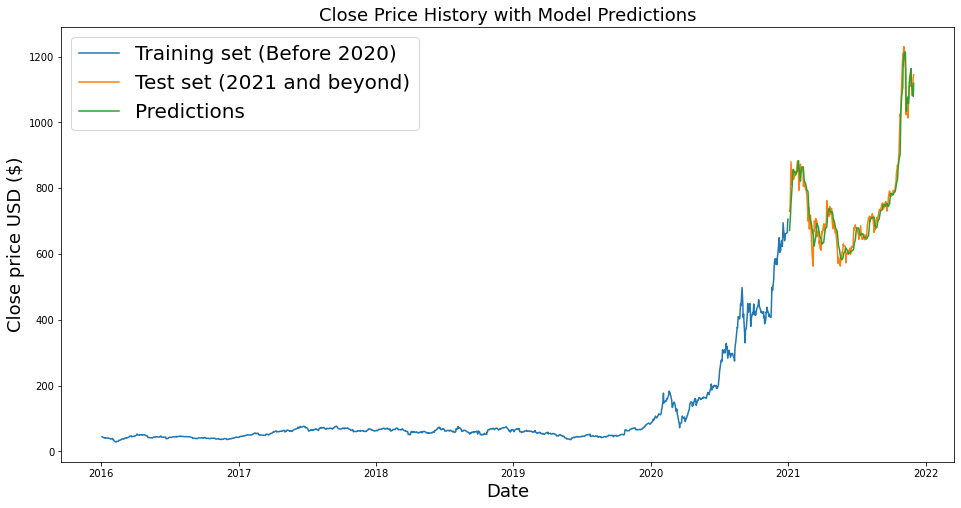

In [370]:
plot_predictions(df_train = df[:'2020'].iloc[:,3:4], df_test = df['2021':].iloc[:,3:4], predictions = predictions)

In [312]:
# Model Notes 

# Simple RNN
  # SS, neurons = 10, look_back = 10, epoch = 100 - rmse = 3.015
  # MM, neurons = 10, look_back = 10, epoch = 100 - rmse = 3.02
  # MM, neurons = 10, look_back = 10, epoch = 100 - rmse = 3.02
    # The loss doesn't really change after 150
  # SS, neurons = 10, look_back = 10, epoch = 150 - rmse = 0.816 
    # pretty good!
  # SS, neurons = 10, look_back = 20, epoch = 150 - rmse = 2.23
    # Keep look_back at 10?
  # SS, neurons = 100, look_back = 10, epoch = 150 - rmse = 1.87

# Deep RNN
  # 3 layers, neurons = (10,10,10), look_back = 10, epoch = 150 - rmse = 3.55
    # Takes too long lower epoch to 50
  # 3 layers, neurons = (10,10,10), look_back = 10, epoch = 50 - rmse = 3.55
  # 3 layers, neurons = (10,10,10), look_back = 10, epoch = 50 - rmse = 1.34
  # 3 layers, neurons = (100,10,10) , look_back = 10, epoch = 50 - rmse = 1.50
  # 4 layers, neurons = (10,10,10, 10) , look_back = 10, epoch = 50 - rmse = 4.49

# LSTM
  # 2 layers, neurons = (50,50), look_back = 10, epoch = 50 - rmse = 1.19
  # 2 layers, neurons = (50,50), look_back = 10, epoch = 150 - rmse = 1.09
    # Took too long
  # 2 layers, neurons = (100,50), look_back = 10, epoch = 70 - rmse = 1.12
  # 3 layers, neurons = (100,50,25), look_back = 10, epoch = 70 - rmse = 0.86
    # Good add one more layer?
  # 4 layers, neurons = (100,50,50,25), look_back = 10, epoch = 70 - rmse = 2.01




## Question 10: Model Critique Questions [Bonus: 1 Point]

Sometimes modeling a problem is easy, and other times it can be very challenging. It is often good to take a step back and think about when your model is successful and when it isn't, and why this might be so. This experience is something you will be able to take with you when you work on future models. Think about the way you modelled the stock data and consider the following questions. 

1.   During your modeling process, did you discover anything interesting? 
2.   Did any any problems come up? If so, please describe them and include your thoughts on addressing them.
3.   Do you think anything is missing from this model training pipeline, compared with our previous model training in Assignment 2?
4.   How might you improve your model?

Please write your answers below in a text box or commenting in a code block.

